## MODERN CNN WITH TF-SLIM

In [1]:
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")

CURRENT TF VERSION IS [1.0.1]
PACKAGES LOADED


## LOAD MNIST

In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
valimg     = mnist.validation.images
vallabel   = mnist.validation.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST ready


## DEFINE MODEL

In [3]:
n_input = 784
n_classes = 10
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
is_training = tf.placeholder(tf.bool)

def prelu(_x):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1]
                             , initializer=tf.constant_initializer(0.0)
                             , dtype=tf.float32)
    pos = tf.nn.relu(_x)
    neg = alphas * (_x - abs(_x)) * 0.5
    return pos + neg

def CNN(inputs, is_training=True):
    x   = tf.reshape(inputs, [-1, 28, 28, 1])
    batch_norm_params = {'is_training': is_training, 'decay': 0.9
                         , 'updates_collections': None}
    net = slim.conv2d(x, 32, [5, 5], padding='SAME'
                     , activation_fn       = prelu
                     , weights_initializer = tf.truncated_normal_initializer(stddev=0.01)
                     , normalizer_fn       = slim.batch_norm
                     , normalizer_params   = batch_norm_params
                     , scope='conv1')
    net = slim.max_pool2d(net, [2, 2], scope='pool1')
    net = slim.conv2d(x, 64, [5, 5], padding='SAME'
                     , activation_fn       = prelu
                     , weights_initializer = tf.truncated_normal_initializer(stddev=0.01)
                     , normalizer_fn       = slim.batch_norm
                     , normalizer_params   = batch_norm_params
                     , scope='conv2')
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    net = slim.flatten(net, scope='flatten3')
    net = slim.fully_connected(net, 1024
                    , activation_fn       = prelu
                    , weights_initializer = tf.truncated_normal_initializer(stddev=0.01)
                    , normalizer_fn       = slim.batch_norm
                    , normalizer_params   = batch_norm_params
                    , scope='fc4')
    net = slim.dropout(net, keep_prob=0.7, is_training=is_training, scope='dropout4')  
    out = slim.fully_connected(net, 10, activation_fn=None, normalizer_fn=None, scope='fco')
    return out
print ("NETWORK READY")

NETWORK READY


## DEFINE GRAPH

In [4]:
# PREDICTION
pred = CNN(x, is_training)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


## SAVER

In [5]:
savedir = "nets/cnn_mnist_modern/"
saver = tf.train.Saver(max_to_keep=100)
save_step = 4
if not os.path.exists(savedir):
    os.makedirs(savedir)
print ("SAVER READY")

SAVER READY


## AUGMENTATION

In [6]:
def augment_img(xs):
    out  = np.copy(xs)
    xs_r = np.reshape(xs, [-1, 28, 28])
    for i in range(xs_r.shape[0]):
        xs_img = xs_r[i, :, :]
        bg_value = 0
        # ROTATE
        angle = np.random.randint(-20, 20, 1).astype(float)
        xs_img = ndimage.rotate(xs_img, angle, reshape=False, cval=bg_value)
        # SHIFT
        shift = np.random.randint(-3, 3, 2)
        xs_img = ndimage.shift(xs_img, shift, cval=bg_value)
        # RESHAPE
        xs_v = np.reshape(xs_img, [1, -1])
        out[i, :] = xs_v
    return out

## TEST AUGMENTATION

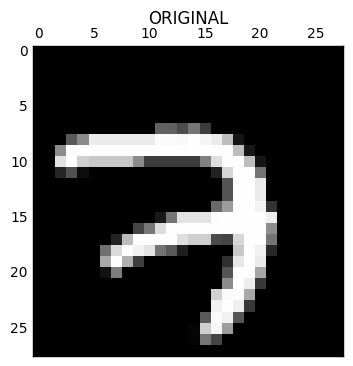

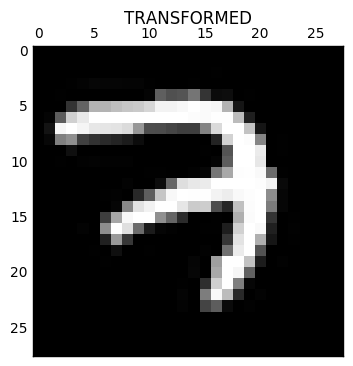

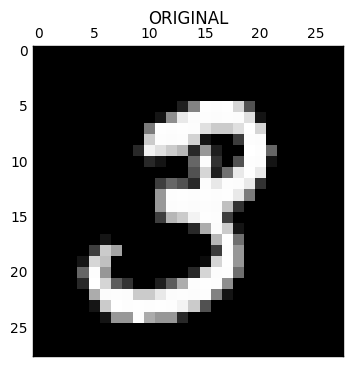

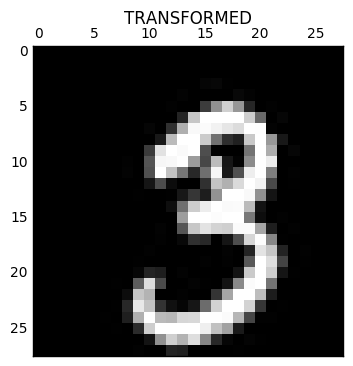

In [7]:
naug = 2
batch_xs = trainimg[:naug, :]
xs2 = augment_img(batch_xs)
for i in range(naug):
    x1 = batch_xs[i, :].reshape([28, 28])
    x2 = xs2[i, :].reshape([28, 28])
    plt.matshow(x1, vmin=0, vmax=1, cmap=plt.cm.gray)
    plt.title("ORIGINAL")
    plt.show()
    plt.matshow(x2, vmin=0, vmax=1, cmap=plt.cm.gray)
    plt.title("TRANSFORMED")
    plt.show()

## RUN

In [8]:
# PARAMETERS
training_epochs = 100
batch_size      = 50
display_step    = 4
val_acc         = 0
val_acc_max     = 0
# LAUNCH THE GRAPH
sess = tf.Session()
sess.run(init)
# OPTIMIZE
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # ITERATION
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # AUGMENT DATA
        batch_xs = augment_img(batch_xs)
        feeds = {x: batch_xs, y: batch_ys, is_training: True}
        sess.run(optm, feed_dict=feeds)
        avg_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = avg_cost / total_batch
    # DISPLAY
    if (epoch+1) % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        randidx = np.random.permutation(trainimg.shape[0])[:500]
        feeds = {x: trainimg[randidx], y: trainlabel[randidx], is_training: False}
        train_acc = sess.run(accr, feed_dict=feeds)
        print (" TRAIN ACCURACY: %.5f" % (train_acc))
        feeds = {x: valimg, y: vallabel, is_training: False}
        val_acc = sess.run(accr, feed_dict=feeds)
        print (" VALIDATION ACCURACY: %.5f" % (val_acc))
    # SAVE
    if (epoch+1) % save_step == 0:
        savename = savedir + "net-" + str(epoch) + ".ckpt"
        saver.save(sess=sess, save_path=savename)
        print (" [%s] SAVED." % (savename))
    # MAXIMUM VALIDATION ACCURACY
    if val_acc > val_acc_max:
        val_acc_max = val_acc
        best_epoch = epoch
        print ("\x1b[31m BEST EPOCH UPDATED!! [%d] \x1b[0m" % (best_epoch))
print ("OPTIMIZATION FINISHED")

Epoch: 004/100 cost: 0.059872630
 TRAIN ACCURACY: 0.99000
 VALIDATION ACCURACY: 0.98960
 [nets/cnn_mnist_modern/net-3.ckpt] SAVED.
 BEST EPOCH UPDATED!! [3] 
Epoch: 008/100 cost: 0.044724675
 TRAIN ACCURACY: 0.99200
 VALIDATION ACCURACY: 0.99400
 [nets/cnn_mnist_modern/net-7.ckpt] SAVED.
 BEST EPOCH UPDATED!! [7] 
Epoch: 012/100 cost: 0.041245670
 TRAIN ACCURACY: 0.99800
 VALIDATION ACCURACY: 0.99400
 [nets/cnn_mnist_modern/net-11.ckpt] SAVED.
 BEST EPOCH UPDATED!! [11] 
Epoch: 016/100 cost: 0.034991559
 TRAIN ACCURACY: 0.99800
 VALIDATION ACCURACY: 0.99280
 [nets/cnn_mnist_modern/net-15.ckpt] SAVED.
Epoch: 020/100 cost: 0.031847603
 TRAIN ACCURACY: 0.99400
 VALIDATION ACCURACY: 0.99280
 [nets/cnn_mnist_modern/net-19.ckpt] SAVED.
Epoch: 024/100 cost: 0.029417414
 TRAIN ACCURACY: 0.99600
 VALIDATION ACCURACY: 0.99460
 [nets/cnn_mnist_modern/net-23.ckpt] SAVED.
 BEST EPOCH UPDATED!! [23] 
Epoch: 028/100 cost: 0.028547484
 TRAIN ACCURACY: 0.99800
 VALIDATION ACCURACY: 0.99380
 [nets/cnn_m

## COMPUTE TEST ACCURACY

In [9]:
restorename = savedir + "net-" + str(best_epoch) + ".ckpt"
print ("LOADING [%s]" % (restorename))
saver.restore(sess, restorename)
feeds = {x: testimg, y: testlabel, is_training: False}
test_acc = sess.run(accr, feed_dict=feeds)
print ("TEST ACCURACY: %.5f" % (test_acc))

LOADING [nets/cnn_mnist_modern/net-87.ckpt]
TEST ACCURACY: 0.99470
